In [1]:
!wget https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json

--2023-06-10 06:12:35--  https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘sarcasm.json’

sarcasm.json        100%[===================>]   5.38M  --.-KB/s    in 0.1s    

2023-06-10 06:12:35 (56.3 MB/s) - ‘sarcasm.json’ saved [5643545/5643545]



In [2]:
#The dataset is saved as a JSON file and you can use Python's json module to load it into your workspace. 
#The cell below unpacks the JSON file into a list.
import json

with open('sarcasm.json','r') as f:
  datastore=json.load(f)

In [3]:
# Non-sarcastic headline
print(datastore[0])

# Sarcastic headline
print(datastore[20000])

{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5', 'headline': "former versace store clerk sues over secret 'black code' for minority shoppers", 'is_sarcastic': 0}
{'article_link': 'https://www.theonion.com/pediatricians-announce-2011-newborns-are-ugliest-babies-1819572977', 'headline': 'pediatricians announce 2011 newborns are ugliest babies in 30 years', 'is_sarcastic': 1}


With that, you can collect all urls, headlines, and labels for easier processing when using the tokenizer. For this lab, you will only need the headlines but we included the code to collect the URLs and labels as well.

In [4]:
sentences=[]
labels=[]
urls=[]

for item in datastore:
  sentences.append(item['headline'])
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

## Hyperparameters

We placed the hyperparameters in the cell below so you can easily tweak it later:

In [24]:
# Number of examples to use for training
training_size=22000

# Vocabulary size of the tokenizer
vocab_size=1000

# Maximum length of the padded sequences
max_length=100

# Output dimensions of the Embedding layer
embedding_dim=16

In [6]:
len(sentences)

26709

In [7]:
len(labels)

26709

## Split the dataset

Next, you will generate your train and test datasets. You will use the `training_size` value you set above to slice the `sentences` and `labels` lists into two sublists: one fore training and another for testing.

In [25]:
training_sentences=sentences[0:training_size]
testing_sentences=sentences[training_size: ]

training_labels=labels[0:training_size]
testing_labels=labels[training_size: ]

## Preprocessing the train and test sets

Now you can preprocess the text and labels so it can be consumed by the model. You use the `Tokenizer` class to create the vocabulary and the `pad_sequences` method to generate padded token sequences. You will also need to set the labels to a numpy array so it can be a valid data type for `model.fit()`.

In [26]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Build and Compile the Model

Next, you will build the model. The architecture is similar to the previous lab but you will use a [GlobalAveragePooling1D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling1D) layer instead of `Flatten` after the Embedding. This adds the task of averaging over the sequence dimension before connecting to the dense layers. See a short demo of how this works using the snippet below. Notice that it gets the average over 3 arrays (i.e. `(10 + 1 + 1) / 3` and `(2 + 3 + 1) / 3` to arrive at the final output.

In [19]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

#total rows, no of rows in each row, no of cols in each row
# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


This added computation reduces the dimensionality of the model as compared to using `Flatten()` and thus, the number of training parameters will also decrease. See the output of `model.summary()` below and see how it compares if you swap out the pooling layer with a simple `Flatten()`.

In [27]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           16000     
                                                                 
 global_average_pooling1d_4   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 24)                408       
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 16,433
Trainable params: 16,433
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

## Train the Model

Now you will feed in the prepared datasets to train the model. If you used the default hyperparameters, you will get around 99% training accuracy and 80% validation accuracy.

*Tip: You can set the `verbose` parameter of `model.fit()` to `2` to indicate that you want to print just the results per epoch. Setting it to `1` (default) displays a progress bar per epoch, while `0` silences all displays. It doesn't matter much in this Colab but when working in a production environment, you may want to set this to `2` as recommended in the [documentation](https://keras.io/api/models/model_training_apis/#fit-method).*

In [29]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
688/688 - 3s - loss: 0.6536 - accuracy: 0.6096 - val_loss: 0.5423 - val_accuracy: 0.7658 - 3s/epoch - 4ms/step
Epoch 2/30
688/688 - 2s - loss: 0.4528 - accuracy: 0.7934 - val_loss: 0.4186 - val_accuracy: 0.8048 - 2s/epoch - 3ms/step
Epoch 3/30
688/688 - 2s - loss: 0.3954 - accuracy: 0.8195 - val_loss: 0.4057 - val_accuracy: 0.8095 - 2s/epoch - 3ms/step
Epoch 4/30
688/688 - 2s - loss: 0.3785 - accuracy: 0.8272 - val_loss: 0.3977 - val_accuracy: 0.8167 - 2s/epoch - 2ms/step
Epoch 5/30
688/688 - 2s - loss: 0.3693 - accuracy: 0.8319 - val_loss: 0.3958 - val_accuracy: 0.8165 - 2s/epoch - 3ms/step
Epoch 6/30
688/688 - 2s - loss: 0.3637 - accuracy: 0.8355 - val_loss: 0.4003 - val_accuracy: 0.8148 - 2s/epoch - 3ms/step
Epoch 7/30
688/688 - 2s - loss: 0.3601 - accuracy: 0.8370 - val_loss: 0.4067 - val_accuracy: 0.8121 - 2s/epoch - 3ms/step
Epoch 8/30
688/688 - 2s - loss: 0.3587 - accuracy: 0.8365 - val_loss: 0.3971 - val_accuracy: 0.8165 - 2s/epoch - 3ms/step
Epoch 9/30
688/688 - 2s 

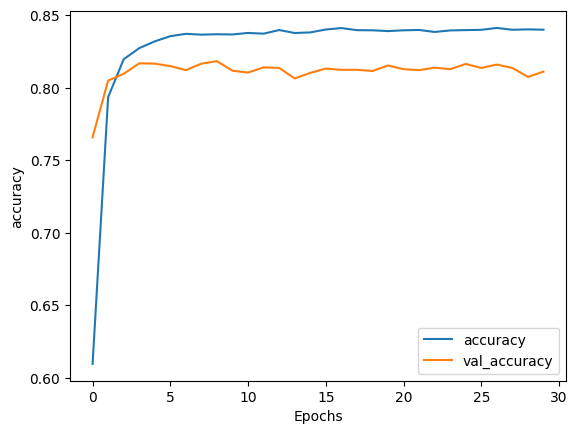

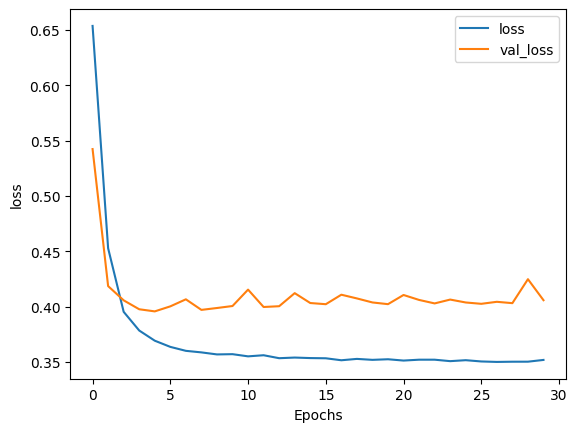

In [30]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Decreasing maxlen, vocab_size= slightly improved val_loss but it remains constant from 5 epochs to 30
slight increase in training_size= similar result

## Visualize Word Embeddings

As before, you can visualize the final weights of the embeddings using the [Tensorflow Embedding Projector](https://projector.tensorflow.org/).

In [31]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 


(1000, 16)


In [32]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(1, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

In [33]:
# Import files utilities in Colab
try:
  from google.colab import files
except ImportError:
  pass

# Download the files
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>